<a href="https://colab.research.google.com/github/sanketnaik99/facial-expression-recognition/blob/main/facial_expression_recogition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('facial-expression-recognition')
jovian.set_colab_id('1WG7B-0y1VLxkksJIbHMcNtzpVGGf0kVP')

     |████████████████████████████████| 71kB 5.9MB/s 


In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sanketnaik99","key":"307831088fc7c3ef481826e17cac508c"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d msambare/fer2013

 81% 49.0M/60.3M [00:01<00:01, 9.87MB/s]
100% 60.3M/60.3M [00:02<00:00, 30.6MB/s]


In [ ]:
! mkdir data
! unzip fer2013.zip -d data

# Imports

In [ ]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
import os

In [ ]:
train_dir = 'data/train/'
valid_dir = 'data/test/'

# Dataset Analysis

In [ ]:
os.listdir(train_dir)

['neutral', 'sad', 'fear', 'disgust', 'angry', 'surprise', 'happy']

The dataset consists of 48x48 pixel grayscale images of faces. The training set consists of 28,709 examples and the test set consists of 3,589 examples.

There are 7 categories as follows:
- Happy
- Fear
- Sad
- Neutral
- Surprise
- Angry
- Disgust

The number of training images for each class is as follows ->

In [ ]:
for class_name in os.listdir(train_dir):
  num_images = len(os.listdir(train_dir + '/' + class_name))
  print(f'{class_name} = {num_images}')

neutral = 4965
sad = 4830
fear = 4097
disgust = 436
angry = 3995
surprise = 3171
happy = 7215


And the number of test images for each class is as follows ->

In [ ]:
for class_name in os.listdir(valid_dir):
  num_images = len(os.listdir(valid_dir + '/' + class_name))
  print(f'{class_name} = {num_images}')

neutral = 1233
sad = 1247
fear = 1024
disgust = 111
angry = 958
surprise = 831
happy = 1774


The validation data has similar problems but since it will only be used to evaluate the model, Data Augmentation isn't necessary for this set.

# Calculating Mean and Std. Deviation


In [ ]:
train_tfms = tt.Compose([
                        #  tt.Grayscale(num_output_channels=1),
                         tt.RandomHorizontalFlip(),
                         tt.RandomCrop(48, padding=4, padding_mode='reflect'),
                         tt.ToTensor(),
                         tt.Normalize([0.5], [0.25])
                         ])

In [ ]:
train_ds = ImageFolder(train_dir, train_tfms)

In [ ]:
def online_mean_and_sd(loader):
    """Compute the mean and sd in an online fashion

        Var[x] = E[X^2] - E^2[X]
    """
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:

        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

        cnt += nb_pixels

    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

In [ ]:
train_dl = DataLoader(train_ds, 256, shuffle=True)
mean, std = online_mean_and_sd(train_dl)
print(mean, std)

tensor([0.0314, 0.0314, 0.0314]) tensor([1.0188, 1.0188, 1.0188])


# Data Augmentation
The dataset consists of Grayscale images. But the Default behavior of PyTorch's DataLoader is to load the images using PIL which reads every image as an RGB image. So, using the `Grayscale` transform we can load the images as Grayscale images having a single color channel. This is done for both of the sets (training and validation).

In [ ]:
train_tfms = tt.Compose([
                         tt.Grayscale(num_output_channels=3),
                         tt.RandomHorizontalFlip(),
                         tt.RandomCrop(48, padding=4, padding_mode='reflect'),
                         tt.ToTensor(),
                         ])

valid_tfms = tt.Compose([
                        tt.Grayscale(num_output_channels=3),
                        tt.ToTensor(),
                         ])

In [ ]:
train_ds = ImageFolder(train_dir, train_tfms)
valid_ds = ImageFolder(valid_dir, valid_tfms)

In [ ]:
batch_size = 256

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
print(online_mean_and_sd(train_dl))

(tensor([0.5077, 0.5077, 0.5077]), tensor([0.2547, 0.2547, 0.2547]))


In [ ]:
print(online_mean_and_sd(valid_dl))

(tensor([0.5060, 0.5060, 0.5060]), tensor([0.2557, 0.2557, 0.2557]))


In [ ]:
for images, labels in train_dl:
    print('Shape of Each batch:', images.shape)
    break

Shape of Each batch: torch.Size([256, 3, 48, 48])


So we can see that each batch consists of **256** images of size *48x48* pixels.

In [ ]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:81], nrow=9).permute(1, 2, 0).clamp(0,1))
    break

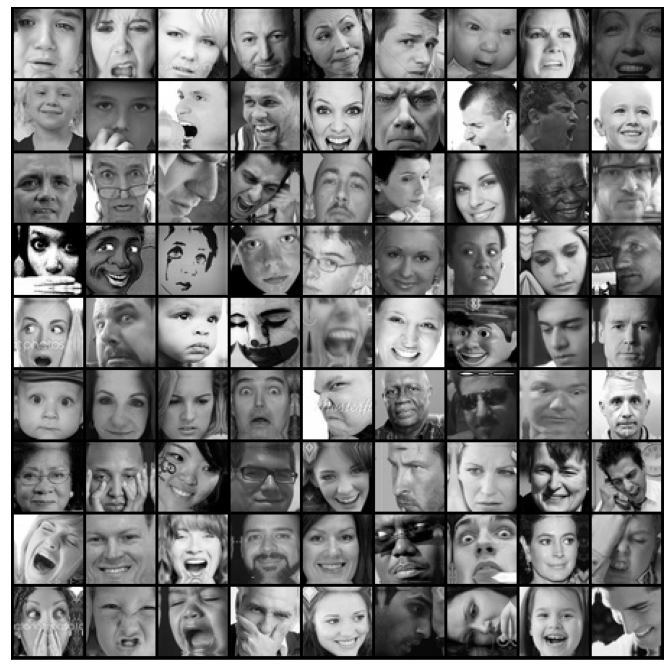

In [ ]:
show_batch(train_dl)

Here we can see that the dataset consists of cropped images of faces and we can see that the images are of various people and their expressions. In some cases even modified images are included (like the image on the 5th row and 3rd column or the image on the 7th row and 5th column).

# DeviceDataLoader Class
This class will be used to transfer the dataset and the model to the GPU memory to improve the speed of training the model.

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
  
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)
    
  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

Now we can transfer the Training and Validation datasets to the GPU memory using the DeviceDataLoader Class.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Base Model
This class will act as the base class for all the model architectures. It includes functions such as `training_step`, `validation_step`, `validation_epoch_end`, `epoch_end` functions.

In [ ]:
class BaseModel(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
  
  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Helper Functions
These functions will be used to plot the accuracy and the loss graphs of the model.

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

# Training Functions
The training cycle uses one-cycle learning rate scheduling which initially starts with a low learning rate and gradually increases is till it reaches a maximum value. This is known as the warm-up step. Once the maximum value is reached, the learning rate starts decreasing until it reaches the initial learning rate value. This is known as the cool-down step. Finally, in the last few iterations the learning rate is lowered below the inital learning rate value and it is called the annihilation phase.

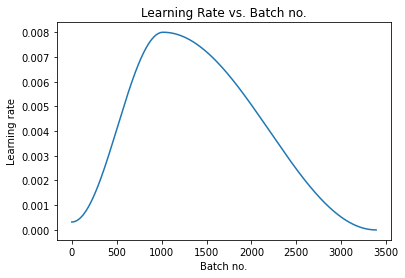

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']
  
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []

  # Set up custom optimizer with weight decay
  optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
  
  # Set up one-cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    lrs = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      # Gradient Clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      # Record and update learning rate
      lrs.append(get_lr(optimizer))
      sched.step()

    # Validation Phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    result['lrs'] = lrs
    model.epoch_end(epoch, result)
    history.append(result)

  return history

# Shallow Convolutional Neural Network
This model consists of the following layers -
- 3x 2D Convolution + Max Pooling
- 2x Linear Transformation
- Output Linear Transformation


In [ ]:
class ShallowConvNet(BaseModel):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # input 1 x 48 x 48
        nn.Conv2d(3, 64, kernel_size=3, padding=1), # Output 64 x 48 x 48
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output 64 x 24 x 24

        # input 64 x 24 x 24
        nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output 128 x 24 x 24
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output 128 x 12 x 12

        # input 128 x 12 x 12
        nn.Conv2d(128, 256, kernel_size=3, padding=1), # Output 256 x 12 x 12
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output 256 x 6 x 6

        nn.Flatten(),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        nn.Linear(1024, 7),
    )

  def forward(self, xb):
    return self.network(xb)

In [ ]:
model = ShallowConvNet()
model

ShallowConvNet(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=9216, out_features=4096, bias=True)
    (14): ReLU()
    (15): Linear(in_features=4096, o

In [ ]:
model = to_device(ShallowConvNet(), device)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 48, 48])
out.shape: torch.Size([256, 7])
out[0]: tensor([ 0.0611,  0.0713,  0.1898,  0.0316,  0.0088,  0.0454, -0.2434],
       device='cuda:0', grad_fn=<SelectBackward>)


## Hyperparameters
The hyperparameters will be the same for all models to make sure the we have an even comparison between the different models.

In [ ]:
epochs = 30
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

## Training
As seen in the hyperparameters, the model will be trained for **30 Epochs** and will have a maximum learning rate of 0.008. Additionally, the Adam optimizer will be used as the optimizer function.

We can check the initial training_loss, validation_loss and validation_accuracy for the model to ensure that the weights have been randomly initialized.

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.13333334028720856, 'val_loss': 1.945956826210022}]

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func,
                         )

Epoch [1], train_loss: 1.8841, val_loss: 1.7134, val_acc: 0.3354
Epoch [2], train_loss: 1.6252, val_loss: 1.5444, val_acc: 0.4130
Epoch [3], train_loss: 1.4449, val_loss: 1.3697, val_acc: 0.4729
Epoch [4], train_loss: 1.3749, val_loss: 2.0723, val_acc: 0.2897
Epoch [5], train_loss: 1.3680, val_loss: 1.3442, val_acc: 0.4953
Epoch [6], train_loss: 1.2830, val_loss: 1.2651, val_acc: 0.5029
Epoch [7], train_loss: 1.2229, val_loss: 1.6579, val_acc: 0.4161
Epoch [8], train_loss: 1.1832, val_loss: 1.3649, val_acc: 0.4698
Epoch [9], train_loss: 1.1443, val_loss: 1.4129, val_acc: 0.4564
Epoch [10], train_loss: 1.1279, val_loss: 1.4716, val_acc: 0.4939
Epoch [11], train_loss: 1.0994, val_loss: 1.7493, val_acc: 0.3940
Epoch [12], train_loss: 1.0806, val_loss: 1.2058, val_acc: 0.5352
Epoch [13], train_loss: 1.0594, val_loss: 1.3320, val_acc: 0.4958
Epoch [14], train_loss: 1.0416, val_loss: 1.1639, val_acc: 0.5655
Epoch [15], train_loss: 1.0223, val_loss: 1.0413, val_acc: 0.6023
Epoch [16], train_l

## Evaluation & Analysis

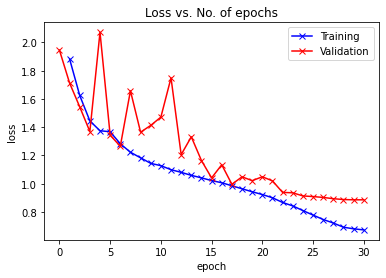

In [ ]:
plot_losses(history)

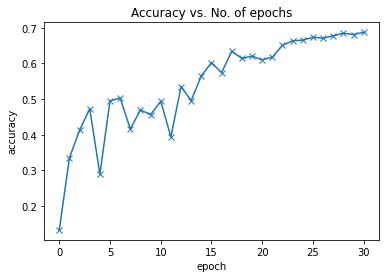

In [ ]:
plot_accuracies(history)

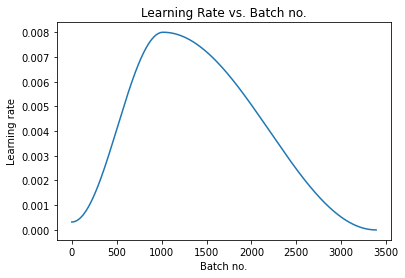

In [ ]:
plot_lrs(history)

## Observations
The following observations can be made after the initial training phase
- **Validation Accuracy** - 68.75%
- **Training Loss** - 0.6731
- **Validation Loss** - 0.8861

## Saving the Model & Metrics


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/fer/models'

In [ ]:
torch.save(model, f'{base_path}/shallow-convnet.pt')
torch.save(model.state_dict(), f'{base_path}/shallow-convnet-state-dict.pt')

In [ ]:
hyperparams = {
    'arch_name': 'shallow_convnet',
    'max_lr': 0.008
}
jovian.log_hyperparams(hyperparams)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
metrics = {
    'epochs': epochs,
    'train_loss': 0.6731,
    'val_loss': 0.8861,
    'val_acc': 0.6875
}
jovian.log_metrics(metrics)

[jovian] Metrics logged.


In [ ]:
jovian.commit(message='Shallow ConvNet')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/sanketnaik99/facial-expression-recognition


'https://jovian.ai/sanketnaik99/facial-expression-recognition'

# Deep Convolutional Neural Network


In [ ]:
class DeepConvNet(BaseModel):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        # input 1 x 48 x 48
        nn.Conv2d(3, 64, kernel_size=3, padding=1), # Output 64 x 48 x 48
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # input 64 x 48 x 48
        nn.Conv2d(64, 64, kernel_size=3, padding=1), # Output 64 x 48 x 48
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output 64 x 24 x 24

        # input 64 x 24 x 24
        nn.Conv2d(64, 128, kernel_size=3, padding=1), # Output 128 x 24 x 24
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # input 128 x 24 x 24
        nn.Conv2d(128, 128, kernel_size=3, padding=1), # Output 128 x 24 x 24
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output 128 x 12 x 12

        # input 128 x 12 x 12
        nn.Conv2d(128, 256, kernel_size=3, padding=1), # Output 256 x 12 x 12
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # Input 256 x 12 x 12
        nn.Conv2d(256, 256, kernel_size=3, padding=1), # Output 256 x 12 x 12
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # Output 256 x 6 x 6

        nn.Flatten(),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(),
        nn.Linear(4096, 1024),
        nn.ReLU(),
        nn.Linear(1024, 7),
    )

  def forward(self, xb):
    return self.network(xb)

In [ ]:
model = DeepConvNet()
model

DeepConvNet(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
model = to_device(DeepConvNet(), device)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 48, 48])
out.shape: torch.Size([256, 7])
out[0]: tensor([ 0.1511, -0.0784,  0.1358, -0.0851,  0.0025,  0.1310, -0.0146],
       device='cuda:0', grad_fn=<SelectBackward>)


## Hyperparameters
The Hyperparameters will be the same as the shallow convolutional neural network to get a better comparison

In [ ]:
epochs = 30
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

## Training
As seen in the hyperparameters, the model will be trained for **30 Epochs** and will have a maximum learning rate of 0.008. Additionally, the Adam optimizer will be used as the optimizer function.

We can check the initial training_loss, validation_loss and validation_accuracy for the model to ensure that the weights have been randomly initialized.

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.12473957985639572, 'val_loss': 1.9457144737243652}]

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func,
                         )

Epoch [1], train_loss: 1.8757, val_loss: 1.8017, val_acc: 0.2726
Epoch [2], train_loss: 1.6610, val_loss: 1.6207, val_acc: 0.3778
Epoch [3], train_loss: 1.4377, val_loss: 1.4405, val_acc: 0.4352
Epoch [4], train_loss: 1.3269, val_loss: 1.4794, val_acc: 0.4283
Epoch [5], train_loss: 1.2833, val_loss: 1.2702, val_acc: 0.5076
Epoch [6], train_loss: 1.2140, val_loss: 1.2144, val_acc: 0.5205
Epoch [7], train_loss: 1.1764, val_loss: 1.2017, val_acc: 0.5536
Epoch [8], train_loss: 1.1250, val_loss: 1.2478, val_acc: 0.5228
Epoch [9], train_loss: 1.1019, val_loss: 1.2626, val_acc: 0.5265
Epoch [10], train_loss: 1.0778, val_loss: 1.1587, val_acc: 0.5595
Epoch [11], train_loss: 1.0530, val_loss: 1.2446, val_acc: 0.5331
Epoch [12], train_loss: 1.0394, val_loss: 1.2060, val_acc: 0.5380
Epoch [13], train_loss: 1.0226, val_loss: 1.2181, val_acc: 0.5494
Epoch [14], train_loss: 1.0078, val_loss: 1.1954, val_acc: 0.5651
Epoch [15], train_loss: 0.9948, val_loss: 0.9873, val_acc: 0.6290
Epoch [16], train_l

## Evaluation & Analysis

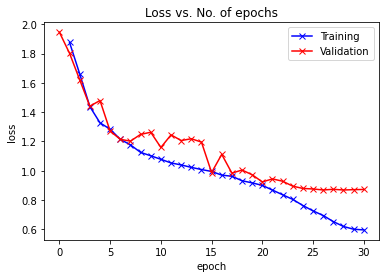

In [ ]:
plot_losses(history)

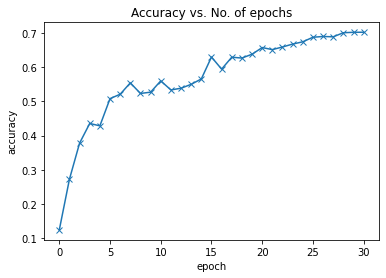

In [ ]:
plot_accuracies(history)

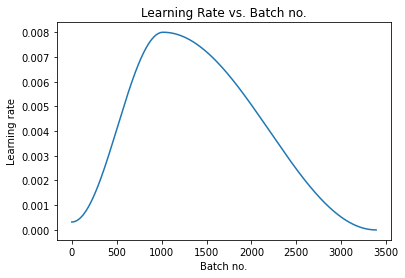

In [ ]:
plot_lrs(history)

## Observations
The following observations can be made after the initial training phase
- **Validation Accuracy** - 70.13%
- **Training Loss** - 0.5954
- **Validation Loss** - 0.8718

## Saving the Model & Metrics


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/fer/models'

In [ ]:
torch.save(model, f'{base_path}/deep-convnet.pt')
torch.save(model.state_dict(), f'{base_path}/deep-convnet-state-dict.pt')

In [ ]:
hyperparams = {
    'arch_name': 'deep_convnet',
    'max_lr': 0.008
}
jovian.log_hyperparams(hyperparams)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
metrics = {
    'epochs': epochs,
    'train_loss': 0.5954,
    'val_loss': 0.8718,
    'val_acc': 0.7013
}
jovian.log_metrics(metrics)

[jovian] Metrics logged.


In [ ]:
jovian.commit(message='Deep ConvNet')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/sanketnaik99/facial-expression-recognition


'https://jovian.ai/sanketnaik99/facial-expression-recognition'

# Residual Network (ResNet)
A residual neural network (ResNet) is an artificial neural network (ANN) of a kind that builds on constructs known from pyramidal cells in the cerebral cortex. Residual neural networks do this by utilizing skip connections, or shortcuts to jump over some layers.

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            ]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet(BaseModel):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [ ]:
model = ResNet(3, 7)
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

In [ ]:
model = to_device(ResNet(3, 7), device)

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([256, 3, 48, 48])
out.shape: torch.Size([256, 7])
out[0]: tensor([-2.0389,  2.1635,  1.1511,  0.2549, -1.2555,  0.2418,  1.9079],
       device='cuda:0', grad_fn=<SelectBackward>)


## Hyperparameters
The Hyperparameters will be the same as the neural networks to get a better comparison

In [ ]:
epochs = 30
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

## Training
As seen in the hyperparameters, the model will be trained for **30 Epochs** and will have a maximum learning rate of 0.008. Additionally, the Adam optimizer will be used as the optimizer function.

We can check the initial training_loss, validation_loss and validation_accuracy for the model to ensure that the weights have been randomly initialized.

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.01770833320915699, 'val_loss': 1.9569865465164185}]

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip,
                         weight_decay=weight_decay,
                         opt_func=opt_func,
                         )

Epoch [1], train_loss: 1.8075, val_loss: 1.4425, val_acc: 0.4517
Epoch [2], train_loss: 1.4204, val_loss: 1.2679, val_acc: 0.5177
Epoch [3], train_loss: 1.2793, val_loss: 1.2385, val_acc: 0.5222
Epoch [4], train_loss: 1.2125, val_loss: 1.2345, val_acc: 0.5342
Epoch [5], train_loss: 1.1797, val_loss: 1.1563, val_acc: 0.5583
Epoch [6], train_loss: 1.1486, val_loss: 1.1443, val_acc: 0.5642
Epoch [7], train_loss: 1.1179, val_loss: 1.1383, val_acc: 0.5691
Epoch [8], train_loss: 1.0950, val_loss: 1.3068, val_acc: 0.5410
Epoch [9], train_loss: 1.0695, val_loss: 1.4324, val_acc: 0.5187
Epoch [10], train_loss: 1.0398, val_loss: 1.5050, val_acc: 0.4140
Epoch [11], train_loss: 1.0252, val_loss: 1.0256, val_acc: 0.6232
Epoch [12], train_loss: 0.9910, val_loss: 1.0129, val_acc: 0.6195
Epoch [13], train_loss: 0.9827, val_loss: 1.0657, val_acc: 0.5911
Epoch [14], train_loss: 0.9730, val_loss: 1.1815, val_acc: 0.5698
Epoch [15], train_loss: 0.9435, val_loss: 0.9880, val_acc: 0.6278
Epoch [16], train_l

## Evaluation & Analysis

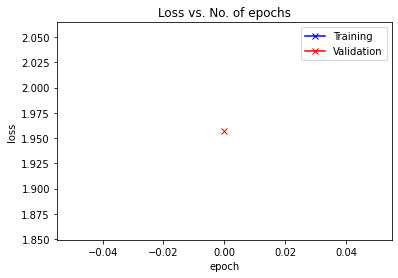

In [ ]:
plot_losses(history)

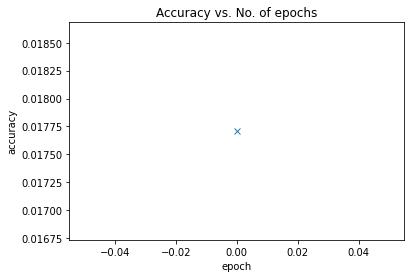

In [ ]:
plot_accuracies(history)

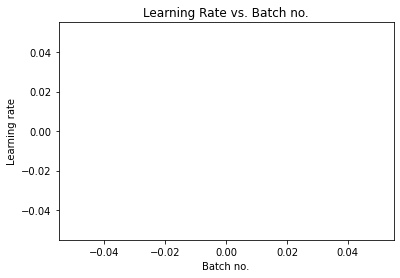

In [ ]:
plot_lrs(history)

## Observations
The following observations can be made after the initial training phase
- **Validation Accuracy** - 71.48%
- **Training Loss** - 0.3619
- **Validation Loss** - 0.9279

## Saving the Model & Metrics


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/fer/models'

In [ ]:
torch.save(model, f'{base_path}/resnet9.pt')
torch.save(model.state_dict(), f'{base_path}/resnet9-state-dict.pt')

In [ ]:
hyperparams = {
    'arch_name': 'resnet9',
    'max_lr': 0.008
}
jovian.log_hyperparams(hyperparams)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Hyperparams logged.


In [ ]:
metrics = {
    'epochs': epochs,
    'train_loss': 0.3619,
    'val_loss': 0.9279,
    'val_acc': 0.7148
}
jovian.log_metrics(metrics)

[jovian] Metrics logged.


In [ ]:
jovian.commit(message='Resnet9')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/sanketnaik99/facial-expression-recognition


'https://jovian.ai/sanketnaik99/facial-expression-recognition'